In [20]:
title = list('SomeTitleWithCaps.mp3')
for i, s in enumerate(title):
    if s.isupper():
        title[i] = ' ' + s
# title = ''.join(title).strip()
print(title)

[' S', 'o', 'm', 'e', ' T', 'i', 't', 'l', 'e', ' W', 'i', 't', 'h', ' C', 'a', 'p', 's', '.', 'm', 'p', '3']


### Start of learnings from [Python 3 Metaprogramming | David Beazley](https://www.youtube.com/watch?v=sPiWg5jSoZI)

In [3]:
# Python 3 has keyword only Args, if you write a function definition as:
# Source: 

def function(first_arg, *, second_arg=None):
    print(first_arg, second_arg)

function(1, second_arg=3)   # works
function(1, 3)              # Error

1 3


TypeError: function() takes 1 positional argument but 2 were given

#### Closures

In [4]:
def make_adder(x, y):
    def add():
        return x + y
    return add   # this function (make_adder) returns a function (add)

# * Local Variables are captured

a = make_adder(2, 3)
b = make_adder(10, 20)

print(a())
print(b())

5
30


In [ ]:
#### Classes

In [6]:
#### Special Methods
class Array:
    def __getitem__(self, index):
        ...
    def __setitem___(self, index, value):
        ...
    def __delitem__(self, index):
        ...
    def __contains__(self, item):
        ...

# Point: Almost everything can be customized

In [7]:
#### Inheritance in classes

In [8]:
#### Dictionaries
# Objects are layered on dictionaries
class Spam:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def foo(self):
        pass

a = Spam(2, 3)
print(a.__dict__)
print(Spam.__dict__['foo'])

{'x': 2, 'y': 3}
<function Spam.foo at 0x10d5a0c80>


#### Metaprogramming Basics

##### Problem: Debugging
- Illustrate basics with a simple problem
- Debugging
- Not the only application, but simple enough to fit on slides (:facepalm:)

In [9]:
# E.g. debugging with print, but what if you have many functions
# you will need to add print statement for each of the function - that is
# code repetition

def add(x, y):
    print('add')
    return x + y
def sub(x, y):
    print('sub')
    return x - y
def mul(x, y):
    print('mul')
    return x * y
# We have already repeated the line "print" three times in above three functions

# Enter Decorators

##### Decorators
- A decorator is a function that creates a wrapper around another function
- The wrapper is a new function that works exactly like the original function (same arguments, same return value) excep that some kind of extra processing is carried out

In [22]:
# e.g
def debug(func):
    # takes a function as input
    # func is the function to be wrapped
    def wrapper(*args, **kwargs):
        print(func.__name__)
        return func(*args, **kwargs)
    return wrapper

@debug
def add(x, y):
    """
    Add two numbers
    """
    return x + y

@debug
def sub(x, y):
#     print('sub')
    return x - y

@debug
def mul(x, y):
#     print('mul')
    return x * y

print(add(1, 2))
# However we lost some details in the process
# e.g.
print('-----')
print(add) # returns meaningless <function debug.<locals>.wrapper ...>
help(add)  # again returns meaningless stuff on wrapper function

add
3
-----
<function debug.<locals>.wrapper at 0x10d7bc950>
Help on function wrapper in module __main__:

wrapper(*args, **kwargs)
    # takes a function as input
    # func is the function to be wrapped



In [21]:
# So we have to do some technicality on our wrapper function
# get wraps from functools and apply that as the decorator on the internal
# function that will be returned by the decorator

from functools import wraps

def debug_updated(func):
    @wraps(func)   # This copies metadata from one function to the another
    def wrapper(*args, **kwargs):
        print(func.__name__)
        return func(*args, **kwargs)
    return wrapper

# Let's try this decorator
@debug_updated
def add(x, y):
    """
    Add two numbers
    """
    return x + y

print(add(1, 2))
print('-----')
print(add)
help(add)

add
3
-----
<function add at 0x10d7bcf28>
Help on function add in module __main__:

add(x, y)
    Add two numbers



In [24]:
##### __qualname__ attribute in Python 3 - helpful to use with classes
# qualname prints out the class name along with method name
# debug with __qualname__ instead of __name__
def debug_with_qualname(func):
    @wraps(func)   # This copies metadata from one function to the another
    def wrapper(*args, **kwargs):
        print(func.__qualname__)
        return func(*args, **kwargs)
    return wrapper

# Let's try this decorator
@debug_with_qualname
def add(x, y):
    """
    Add two numbers
    """
    return x + y

print(add(1, 2))
print('-----')
print(add)
help(add)

add
3
-----
<function add at 0x10e0800d0>
Help on function add in module __main__:

add(x, y)
    Add two numbers



##### Big Picture
- Debugging code is isolated to a single location
- This makes it easy to change (or disable)
- User of a decorator doesn't worry about it
- That's really the whole idea

In [36]:
# e.g. using decorator for logging
from functools import wraps
import logging

def debug(func):
    log = logging.getLogger(func.__module__)
    msg = func.__qualname__
    
    @wraps(func)
    def wrapper(*args, **kwargs):
        log.debug(msg)
        return func(*args, **kwargs)

    return wrapper

# Key Idea: Can change decorator independently of code that uses it
## E.g. using an environment variable or some form of flag

In [37]:
# What if you wanted to add some prefix to the print statement that we
# did earlier in `add`, `sub`, etc.
# e.g.
def add(x, y):
    print('***add') # instead of print(add)
    return x + y

##### Enter Decorator with Args
- calling convention

```
@decorator(args)
def func():
    pass
```
- Evaluates as
`func = decorator(args)(func)`
- Little weird -- two levels of calls

In [39]:
# Using decorator with args:
from functools import wraps

def debug(prefix=''):
    def decorate(func):
        msg = prefix + func.__qualname__
        @wraps(func)
        def wrapper(*args, **kwargs):
            print(msg)
            return func(*args, **kwargs)
        return wrapper
    return decorate

# - Usage
@debug(prefix='***')
def add(x, y):
    return x + y

print(add(1, 2))

***add
3


In [41]:
# A Reformulation of above

from functools import wraps, partial

def debug(func=None, *, prefix=''):
    if func is None:
        return partial(debug, prefix=prefix)
    
    msg = prefix + func.__qualname__
    @wraps(func)
    def wrapper(*args, **kwargs):
        print(msg)
        return func(*args, **kwargs)
    return wrapper

# A test of your function calling skills

@debug(prefix='---')
def add(x, y):
    return x + y

print(add(0, 1))

---add
1


##### Debug all of This
- Debug all of the methods of a class
```
class Spam:
    @debug
    def grok(self):
        pass
       
    @debug
    def bar(self):
        pass

    @debug
    def foo(self):
        pass
```
- Can you decorate all methods at once?

In [47]:
# Class Decorator
def debugmethods(cls):
    # cls is a class
    for name, val in vars(cls).items():
        if callable(val):
            setattr(cls, name, debug(val))
    return cls

# - Idea:
#     * Walkthrough class dictionary
#     * Identify callables (e.g. methods)
#     * Wrap with a decorator

# So now, we can do something like this:

@debugmethods
class Spam:
    def grok(self):
        pass
       
    def bar(self):
        pass

    def foo(self):
        pass

# - One decorator application
# - Covers all definitions within the class
# - It even mostly works...

# Limitations:
#     - Does not work with classmethods and staticmethods
#     - Only instance methods are wrapped
#     - Why? Exercise for the reader...

In [53]:
# Brain surgery of a class
# Yanking off the __getattribute__ method on a class

def debugattr(cls):
    orig_getattribute = cls.__getattribute__
    
    def __getattribute__(self, name):
        print('Getting attribute:', name)
        return orig_getattribute(self, name)
    
    cls.__getattribute__ = __getattribute__
    
    return cls

# * We did a rewrite of the part of the class itself

@debugattr
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
p = Point(1, 2)
print(p.x)
print(p.y)

Getting attribute: x
1
Getting attribute: y
2


In [54]:
# Debug all the classes in a file such that we do not have to write
# @debugmethods decorator for each class, current code:
@debugmethods
class Base:
    ...

@debugmethods
class Spam(Base):
    ...

@debugmethods
class Grok(Base):
    ...

# Notice there are three debugmethods decorators, what if you wanted
# to debug all the classes but without having to write debugmethods so 
# many times

In [55]:
# Obvious solution - define a metaclass
class debugmeta(type):
    # Metaclasses inherit from `type` which is like the base metaclass
    # Read RealPython - Metaclasses for more info on this
    
    def __new__(cls, clsname, bases, clsdict):
        clsobj = super().__new__(cls, clsname, bases, clsdict)
        
        clsobj = debugmethods(clsobj)
        return clsobj

# * Idea
#     - Class gets created normally in line `clsobj = super().__new__(cls, clsname, bases, clsdict)`
#     - Immediately wrapped by class decorator `debugmethods` in line: `clsobj = debugmethods(clsobj)`

# Usage of debugmeta
class Base(metaclass=debugmeta):
    ...

class Spam(Base):
    ...

In [58]:
x = 42
print(type(x))

s = 'Hello'
print(type(s))

item = [1, 2, 3]
print(type(item))

print(type(type(x)))
print(type(type(s)))
print(type(type(item)))

# Every single item in Python has a type
# However the type of the <type> itself is `type`
# so type(int) is `type`

# In python, every type is defined by a class.

# So this means, somewhere `type` has to be a class from where other "types"
# such as int, str, etc. inherit

<class 'int'>
<class 'str'>
<class 'list'>
<class 'type'>
<class 'type'>
<class 'type'>


#### Class Deconstructed

In [ ]:
# * Consider a class
class Spam(Base):
    def __init__(self, name):
        self.name = name
    def bar(self):
        print 'I am Spam.bar'

# * What are its components?
#     - Name - "Spam"
#     - Base Classes - (Base, )
#     - Functions (__init__, bar)

#### Using a MetaClass
* Metaclasses get information about class definitions at the time of definitions
    - Can inspect this data
    - Can modify this data
* Essentially, similar to a class decorator
* Question: Why would you use one?



#### Answer - Inheritance

- Metaclasses **propagate** down hierarchies

```
class Base(metaclass=mytype):
    ...

class Spam(Base):      # metaclass=mytype
    ...

class Grok(Spam):      # metaclass=mytype
    ...
```

- Think of it as genetic mutation

### Big Picture

- Its mostly about wrapping/rewriting
    - Decorators: Functions
        * Decorators are used to wrap around functions
    - Class Decorators: Classes
        * Class decorators are used to wrap around classes
    - Metaclasses: Class hierarchies
        * Metaclasses are used to wrap entier hierarchies of a class that derives from a particular metaclass
- You have the power to change things

## Journey So far
- Pretty well trodden territory in Python 2 world
- Only a few Python 3 specific changes (e.g. `__qualname__`)

## Let us look at something Python 3 specific

### Problem: Structures

In [59]:
class Stock:
    def __init__(self, name, shares, price):
        self.name = name
        self.shares = shared
        self.price = price
    
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
class Host:
    def __init__(self, address, port):
        self.address = address
        self.port = port

In [78]:
# We can generalise this a little bit by using a base class, e.g.
class Structure:
    _fields = []
    def __init__(self, *args):
        print('self.__class__', self.__class__)
        print('self.__class__._fields', self.__class__._fields)
        print('*args', *args)
        print('zip(self.__class__._fields, args)', list(zip(self.__class__._fields, args)))
        for name, val in zip(self.__class__._fields, args):
            print('Name and its value:', name, val)
            setattr(self, name, val)

class Stock(Structure):
    _fields = ['name', 'shares', 'price']
    
# class Point(Structure):
#     _fields = ['x', 'y']

# class Host(Structure):
#     _fields = ['address', 'port']

s = Stock('GOOG', 100, 490.1)
# print(s.name, s.shares, s.price)

self.__class__ <class '__main__.Stock'>
self.__class__._fields ['name', 'shares', 'price']
*args GOOG 100 490.1
zip(self.__class__._fields, args) [('name', 'GOOG'), ('shares', 100), ('price', 490.1)]
Name and its value: name GOOG
Name and its value: shares 100
Name and its value: price 490.1


In [79]:
# Problem with this approach:
# - You lose a lot of debugging information
help(Stock)

Help on class Stock in module __main__:

class Stock(Structure)
 |  Method resolution order:
 |      Stock
 |      Structure
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  _fields = ['name', 'shares', 'price']
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Structure:
 |  
 |  __init__(self, *args)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from Structure:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [80]:
# if you do not call it with right number of arguments it doesn't fail
s = Stock('GOOG', 100) # Third positional argument missing
print(s.name)
print(s.shares)
print(s.price)

self.__class__ <class '__main__.Stock'>
self.__class__._fields ['name', 'shares', 'price']
*args GOOG 100
zip(self.__class__._fields, args) [('name', 'GOOG'), ('shares', 100)]
Name and its value: name GOOG
Name and its value: shares 100
GOOG
100


AttributeError: 'Stock' object has no attribute 'price'

In [81]:
# You don't get keyword arguments
s = Stock(name='Goog')

TypeError: __init__() got an unexpected keyword argument 'name'

In [83]:
# Missing calling signatures
import inspect
print(inspect.signature(Stock))

(*args)


### Signatures is a new thing in Python 3

#### New Approach: Signatures
* build a function signature object

```
from inspect import Parameter, Signature

fields = ['name', 'shares', 'price']
parms = [
    Parameter(name, Parameter.POSITIONAL_OR_KEYWORD) for name in fields
]
sig = Signature(parms)
```

* Signatures are more than just metadata

In [85]:
from inspect import Parameter, Signature

fields = ['name', 'shares', 'price']
parms = [Parameter(name, Parameter.POSITIONAL_OR_KEYWORD) for name in fields]
sig = Signature(parms)
print(parms)
print(sig)

[<Parameter "name">, <Parameter "shares">, <Parameter "price">]
(name, shares, price)


#### Signature Binding
- This is what you can do with signatures
- Argument binding

```
def func(*args, **kwargs):
    bound_args = sig.bind(*args, **kwargs)
    for name, val in bound_args.arguments.items():
        print('{} = {}'.format(name, val))
```

- `sig.bind()` binds positional/keyword args to signature
* `.arguments` is an `OrderedDict` of passed values

In [91]:
# So I have a sig object from previous code snipppet
print(sig)    # (name, shares, price)

# Let us bind this to a function's signature
def foo(*args, **kwargs):
    bound = sig.bind(*args, **kwargs)
    for name, val in bound.arguments.items():
        print('{}: {}'.format(name, val))

foo('AMZN', 100, 299)

# This also supports keyword arguments because while creating the
# signature we mentioned `Parameter.POSITIONAL_OR_KEYWORD`
foo(name='SHARE', price=299, shares=1)

# It will also do argument checking
foo(1,2) # TypeError: missing a required argument: 'price'

(name, shares, price)
name: AMZN
shares: 100
price: 299
name: SHARE
shares: 1
price: 299


TypeError: missing a required argument: 'price'

In [101]:
# So let us use Signature with our original Structure code
from inspect import Parameter, Signature

def make_signature(names):
    return Signature(
        Parameter(name,
                 Parameter.POSITIONAL_OR_KEYWORD)
        for name in names
    )

class Structure:
    __signature__ = make_signature([])
    
    def __init__(self, *args, **kwargs):
        bound = self.__signature__.bind(*args, **kwargs)
        
        for name, val in bound.arguments.items():
            setattr(self, name, val)
            
# So now, all the classes are gonna be a little bit different
class Stock(Structure):
    __signature__ = make_signature(['name', 'shares', 'price'])
    
class Point(Structure):
    __signature__ = make_signature(['x', 'y'])

class Address(Structure):
    __signature__ = make_signature(['hostname', 'port'])

# now the classes will behave so much nicer!
# for example - now classes will support combination of keyword and positional arguments
s = Stock('Goog', 100, 490.1)
print(s.name, s.shares)

# Let us try mix of keyword and positional arguments
new_s = Stock(name='Goog', price=300, shares=1)
print(new_s.name, new_s.price, new_s.shares)

help(Stock) # Shows proper signature as <Signature (name, shares, price)>

import inspect
inspect.signature(Stock) # shows the signature object - <Signature (name, shares, price)>

Goog 100
Goog 300 1
Help on class Stock in module __main__:

class Stock(Structure)
 |  Method resolution order:
 |      Stock
 |      Structure
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  __signature__ = <Signature (name, shares, price)>
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Structure:
 |  
 |  __init__(self, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from Structure:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



<Signature (name, shares, price)>

### New Problem
* This is rather annoying

```
class Stock(Structure):
    __signature__ = make_signature(['name', 'shares', 'price'])
    
class Point(Structure):
    __signature__ = make_signature(['x', 'y'])

class Address(Structure):
    __signature__ = make_signature(['hostname', 'port'])
```

* Can't it be simplified in some way?

### Solutions
* Ah, a problem involving class definitions
    - Class decorators
    - Metaclasses
* Which seems more appropriate?
* Let's explore both options

#### Class Decorator solution

In [106]:
def add_signature(*names):
    def decorate(cls):
        cls.__signature__ = make_signature(names)
        return cls
    return decorate

##### Usage

In [107]:
@add_signature('name', 'shares', 'price')
class Stock(Structure):
    pass

#### Metaclass solution

In [7]:
from inspect import Parameter, Signature

def make_signature(names):
    return Signature(
        Parameter(name,
                 Parameter.POSITIONAL_OR_KEYWORD)
        for name in names
    )

class StructMeta(type):
    def __new__(cls, name, bases, clsdict):
        # We are making the class
        clsobj = super().__new__(cls, name, bases, clsdict)
        
        # We are making the signature for the class
        sig = make_signature(clsobj._fields)
        
        # Setting the signature on the class
        setattr(clsobj, '__signature__', sig)
        
        return clsobj

# Usage
class Structure(metaclass=StructMeta):
    _fields = []
    def __init__(self, *args, **kwargs):
        bound = self.__signature__.bind(*args, **kwargs)
        for name, val in bound.arguments.items():
            setattr(self, name, val)

# Now we can go back to simplified version
class Stock(Structure):
    _fields = ['name', 'shares', 'price']
    
class Point(Structure):
    _fields = ['x', 'y']

class Host(Structure):
    _fields = ['address', 'port']
    
# The good things about this is that the user does not have to worry.
# Once the metaclass is injected in the base class, it is all taken care of

x = Stock('GOOG', price=100, shares=10)
x.shares
x.name

'GOOG'

## Descriptors- Owning the Dot Notation (Raymond Hettinger)

In [10]:
# Descriptor Protocol
# * Properties are implemented via descriptors

class Descriptor:
    def __get__(self, instance, cls):
        ...
    def __set__(self, instance, value):
        ...
    def __delete__(self, instance):
        ...

# * Customized processing of attribute access

In [15]:
# Let us define a proper descriptor
class Descriptor:
    def __init__(self, name=None):
        self.name = name
        
    def __get__(self, instance, cls):
        # instance: is the instance being manipulated
        # e.g. Stock instance
        print('instance.__dict__', instance.__dict__)
        print('vars(instance)', vars(instance))
        print("Get", self.name)
        return instance.__dict__[self.name]
    
    def __set__(self, instance, value):
        print("Set", self.name, value)
        instance.__dict__[self.name] = value
    
    def __delete__(self, instance):
        print("Delete", self.name)
        del instance.__dict__[self.name]

# Now, let us use the above defined Descriptor in Stock class
class Stock(Structure):
    _fields = ['name', 'shares', 'price']
    name = Descriptor('name')
    shares = Descriptor('shares')
    price = Descriptor('price')

a = Stock('acme', 50, 91.1)
print(a.shares)
a.shares = 51
del a.shares

Set name acme
Set shares 50
Set price 91.1
instance.__dict__ {'name': 'acme', 'shares': 50, 'price': 91.1}
vars(instance) {'name': 'acme', 'shares': 50, 'price': 91.1}
Get shares
50
Set shares 51
Delete shares


In [22]:
# Using descriptors to build Type Checking
class Typed(Descriptor):
    ty = object     # Expected type
    def __set__(self, instance, value):
        if not isinstance(value, self.ty):
            raise TypeError('Expected {}'.format(self.ty))
        super().__set__(instance, value)

# Specialization
class Integer(Typed):
    ty = int
class Float(Typed):
    ty = float
class String(Typed):
    ty = str

# Now let us use this in Stock class (think: is this how Django creates all the CharField, BooleanField, etc fields?)
class Stock(Structure):
    _fields = ['name', 'shares', 'price']
    name = String('name')
    shares = Integer('shares')
    price = Float('price')

s = Stock('GOOG', 50, 10.0)
s.shares = 'Abc' # Raises TypeError!

<class 'type'>
Set name GOOG
Set shares 50
Set price 10.0


TypeError: Expected <class 'int'>

In [24]:
# Let us do Value/Domain checking
class Positive(Descriptor):
    def __set__(self, instance, value):
        if value < 0:
            raise ValueError('Expected value > 0')
        super().__set__(instance, value)

class PositiveInteger(Integer, Positive):
    # Here we combined type checking and value checking
    # Type - the class instance is an integer
    # Value - the class instance is a positive integer and not just any integer 
    pass

class PositiveFloat(Float, Positive):
    pass

# Let us use PositiveInteger
class Stock(Structure):
    _fields = ['name', 'shares', 'price']
    name = String('name')
    shares = PositiveInteger('shares')
    price = Float('price')

a = Stock('NegativeShares', shares=-10, price=1.0)

Set name NegativeShares


ValueError: Expected value > 0

### Keyword-only Args

In [31]:
# Test how keyword-only args behave
def test_keyword_only_args(*, keyword_only_arg):
    """
    Here the argument "keyword_only_arg" is expected to behave as the name
    says since this argument is after the argument that starts with asterisk (*)
    """
    
    print('keyword_only_arg:', keyword_only_arg)

# Value for "keyword_only_arg" is passed as keyword argument
test_keyword_only_args(keyword_only_arg='value for keyword only arg')

# Value for "keyword_only_arg" is passed as a positional argument, raises TypeError
test_keyword_only_args('value for keyword only arg')

keyword_only_arg: value for keyword only arg


TypeError: test_keyword_only_args() takes 0 positional arguments but 1 was given

#### Annoyance

```
class Stock(Structure):
    _fields = ['name', 'shares', 'price']
    name = SizedRegexString('name', maxlen=8, pat='[A-Z]+$')
    shares = PosInteger('shares')
    price = PosFloat('price')
```

- Still quite a bit of repetition
- Signatures and type checking not unified
- Maybe we can push it further


##### Metaclass as a solution to the problem

- `__prepare__` is a new thing in Python
- `__prepare__` returns the dictionary that is supposed to be used during class creation.
- So using `__prepare__` you can completed get rid of the `_fields` attribute from the `Stock` class definition

- Now if you return an `OrderedDict()` in the `__prepare__` method, it will also remember the order of the declaration of field

#### Performance
##### The Costs

* Option 1: Simple

```
class Stock:
    def __init__(self, name, shares, price):
        self.name = name
        self.shares = shares
        self.price = price
```

* Option 2: Meta

```
class Stock(Structure):
    name = SizedRegexString(...)
    shares = PosInteger()
    price = PosFloat()
```

* A few tests show that Instance creation takes a lot more time in the Meta way of doing things, screenshot:

Screenshot 2020-02-29 at 07.29.44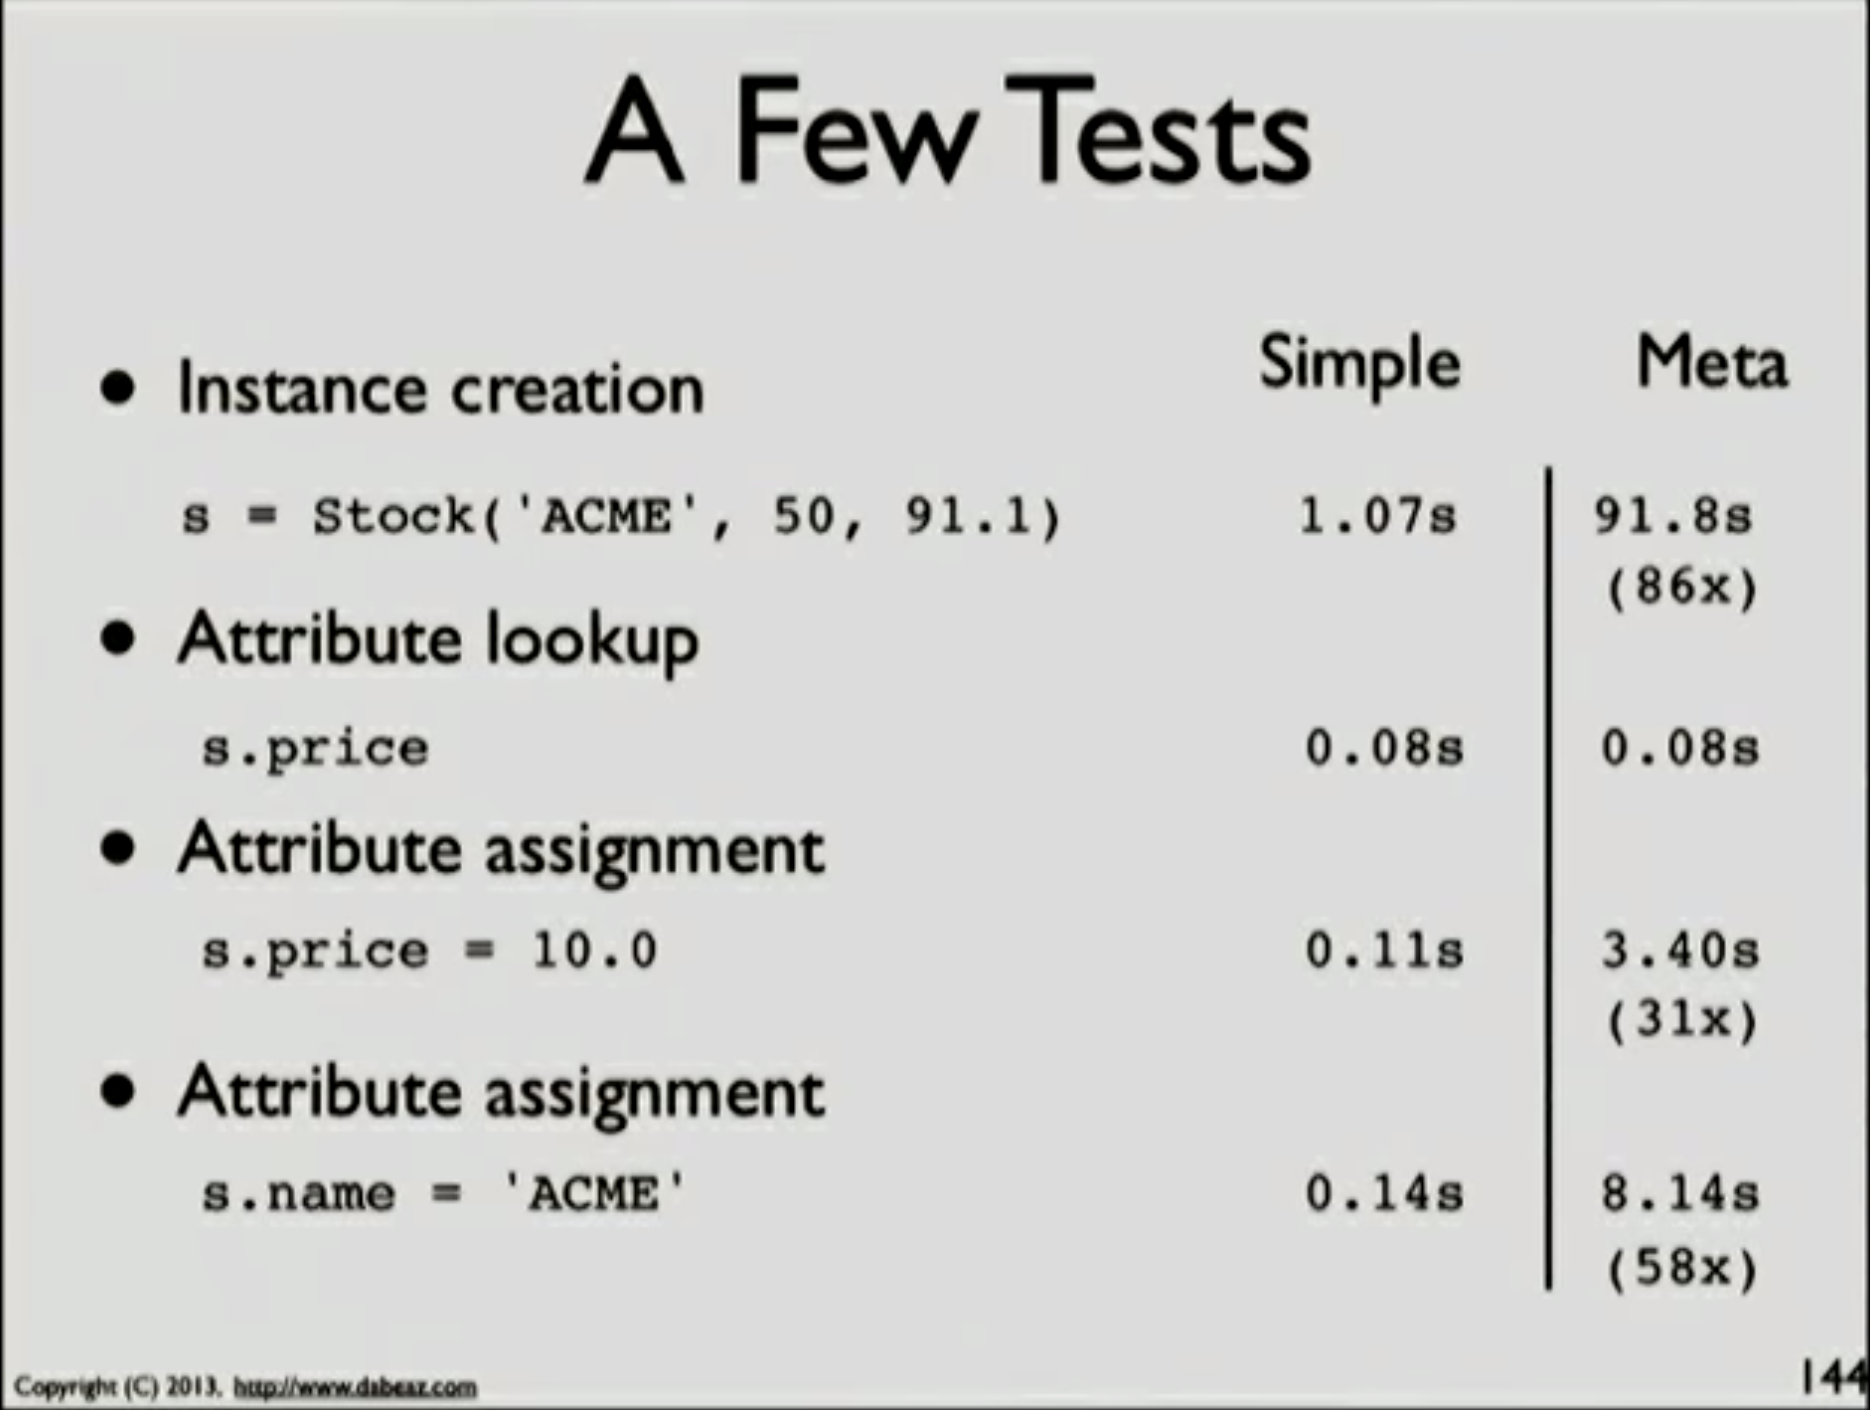